In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR

import statsmodels.api as sm

%matplotlib inline

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
portfolio = pd.read_json('portfolio1.json', orient='records', lines=True)

In [3]:
profile = pd.read_json('profile1.json', orient='records', lines=True)

In [6]:
transcript = pd.read_json('transcriptolan.json', orient='records', lines=True)

In [7]:
def id_mapper_dict():
    """
    In order to create a id dictionary
    1.  customer_id
    2.  offer_type_id
    3. merge all
    """
    # customer_id
    coded_dict = dict()
    cter = 1
    prefix = "C_"
    customer_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = prefix + str(cter)
            cter+=1
        customer_encoded.append(coded_dict[val])
        
    id_dict = dict(zip(profile['id'], customer_encoded))
    
    # offer_type_id
    coded_dict = dict()
    cter = 1
    prefix = "F_"
    offer_encoded = []
    
    for val in portfolio['id']:
        if val not in coded_dict:
            coded_dict[val] = prefix + str(cter)
            cter+=1
        offer_encoded.append(coded_dict[val])
    offer_id_dict = dict(zip(portfolio['id'], offer_encoded))
    
    # merge dictionary
    id_dict.update(offer_id_dict)
    
    return id_dict
id_dict = id_mapper_dict()

In [8]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
portfolio['id'] = portfolio['id'].map(id_dict)

In [11]:
for element in ["web", "email", "mobile", "social"]:
    portfolio[element] = portfolio['channels'].apply(lambda x: 1 if element in x else 0)
portfolio.drop('channels', axis=1, inplace=True)

In [12]:
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,F_1,bogo,10,0,1,1,1
1,10,5,F_2,bogo,10,1,1,1,1
2,0,4,F_3,informational,0,1,1,1,0
3,5,7,F_4,bogo,5,1,1,1,0
4,20,10,F_5,discount,5,1,1,0,0
5,7,7,F_6,discount,3,1,1,1,1
6,10,10,F_7,discount,2,1,1,1,1
7,0,3,F_8,informational,0,0,1,1,1
8,5,5,F_9,bogo,5,1,1,1,1
9,10,7,F_10,discount,2,1,1,1,0


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 796.9+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4042d5b048>,
      dtype=object)

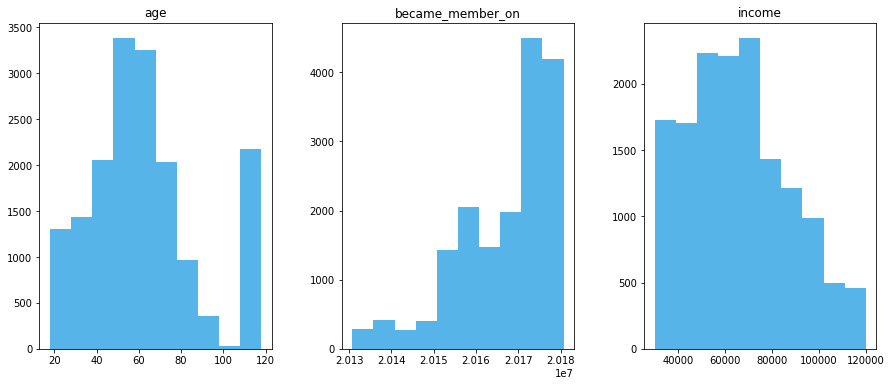

In [14]:
profile.hist(figsize=(15,6), layout=(1,3), color=sns.color_palette('colorblind')[-1], grid=False)

In [15]:
profile[profile['income']<40000].shape[0]/profile.shape[0]

0.11411764705882353

In [16]:
# slice
profile = profile[profile['income'].notnull()].reset_index(drop=True)

# create ordinary/categorical data
profile['age'] = pd.cut(x = profile['age'], 
                               bins = [profile['age'].min(), 30, 45, 60, 80,profile['age'].max()],
                               labels = ['<30','31~45','46~60','61~80','>80'])

profile['became_member_on'] = pd.cut(profile['became_member_on'], 
          bins=[profile['became_member_on'].min(), 20150000, 20160000,20170000, 20180000, profile['became_member_on'].max()], 
          labels = ['<2014','2014','2015','2017','2018'])

# convert id 
profile['id'] = profile['id'].map(id_dict)

In [17]:
profile.head()

,age,became_member_on,gender,id,income
0,46~60,2017,F,C_2,112000.0
1,61~80,2017,F,C_4,100000.0
2,61~80,2018,M,C_6,70000.0
3,61~80,2018,M,C_9,53000.0
4,46~60,2017,M,C_13,51000.0


In [18]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [19]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 11.7+ MB


In [20]:
transcript['event'].unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [21]:
transcript['time'].max()

714

In [22]:
# extract values from dictionary
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])

# map the columns of person and value from id_dict
transcript['person'] = transcript['person'].map(id_dict)
transcript.loc[transcript["event"] != 'transaction',"value"] = transcript.loc[transcript["event"] != 'transaction',"value"].map(id_dict)

In [23]:
# seperate the table of transcript into 4 tables. They are offer_received, offer_viewed, offer_completed, and transcation. 
# and rename the columns respectively. 
offer_received = transcript.query("event == 'offer received'").loc[:,['person','time','value']]
offer_received.columns = ['person','received_time','received_offer']

offer_viewed = transcript.query("event == 'offer viewed'").loc[:,['person','time','value']]
offer_viewed.columns = ['person','viewed_time','viewed_offer']

transaction = transcript.query("event == 'transaction'").loc[:, ['person','time','value']]
transaction.columns = ['person','purchase_time','amount']
transaction['amount'] = transaction['amount'].astype(float)

offer_completed = transcript.query("event == 'offer completed'").loc[:, ['person','time','value']]
offer_completed.columns =  ['person','completed_time','completed_offer']

In [24]:
q1 = transcript['person'].nunique()
q2 = offer_received['person'].nunique()
q3 = q1 - q2
q4 = offer_completed['person'].nunique()
q5 = len(set(offer_received['person']) - set(transaction['person']))
q6 = offer_viewed['person'].nunique()
q7 = len(set(set(offer_received['person']) - set(offer_viewed['person'])) - set(transaction['person']))

In [25]:
print("""
There are %d customers contained in the simulated data set. Only these person who received offers and complete the offers would be awarded. 
%d person received offers while %d person didn't. Each person might receive several types of offer, %d person at least completed an offer and 
were rewarded. %d person received offers but didn't have any consumption records. %d person didn't view any offers they received, however, 
only %d person in them with no transaction records.\n
%d person which hadn't any transaction records are out of the range of this observation.
""" % (q1,q2,q3,q4,q5,q6,q7,q3))


There are 17000 customers contained in the simulated data set. Only these person who received offers and complete the offers would be awarded. 
16994 person received offers while 6 person didn't. Each person might receive several types of offer, 12774 person at least completed an offer and 
were rewarded. 422 person received offers but didn't have any consumption records. 16834 person didn't view any offers they received, however, 
only 10 person in them with no transaction records.

6 person which hadn't any transaction records are out of the range of this observation.



In [26]:
# offer_received_without_informational 
offer_bogo_discount = offer_received.query("not(received_offer == 'F_3' or received_offer == 'F_8')")
offer_informational = offer_received.query("received_offer == 'F_3' or received_offer == 'F_8'")

In [27]:
# prepare
response = offer_bogo_discount.merge(portfolio[['id','duration']], left_on='received_offer', right_on = 'id')
response.drop('id', axis=1, inplace=True)

# connect received offers and viewed offers
response = response.merge(offer_viewed, left_on = ['person','received_offer'], right_on = ['person', 'viewed_offer'])
response['isValid'] = ((response['viewed_time'] - response['received_time']) <= response['duration']) & \
                                ((response['viewed_time'] - response['received_time'] >= 0))
response = response.loc[response['isValid'], :"duration"]

# connect viewed offers and completed offers
response = response.merge(offer_completed, left_on = ['person','received_offer'], right_on = ['person', 'completed_offer'])
response['isValid'] = ((response['completed_time'] - response['received_time']) <= response['duration']) & \
                                ((response['completed_time'] - response['received_time'] >= 0))
response = response.loc[response['isValid'], :"received_offer"]

In [28]:
response['person'].nunique()

1531

In [29]:
response.head()

,person,received_time,received_offer
2,C_175,0,F_4
17,C_982,168,F_4
28,C_2283,0,F_4
35,C_2611,0,F_4
41,C_2894,0,F_4


In [30]:
# prepare
response_info = offer_informational.merge(portfolio[['id','duration']], left_on='received_offer', right_on = 'id')
response_info.drop('id', axis=1, inplace=True)

# connect received offers and viewed offers
response_info = response_info.merge(offer_viewed, left_on = ['person','received_offer'], right_on = ['person', 'viewed_offer'])
response_info['isValid'] = ((response_info['viewed_time'] - response_info['received_time']) <= response_info['duration']) & \
                                ((response_info['viewed_time'] - response_info['received_time'] >= 0))
response_info = response_info.loc[response_info['isValid'], :"duration"]

# connect viewed offers and transaction records
response_info = response_info.merge(transaction, on="person")

def isValid_info(response_info): # valid metric 
    if (response_info['purchase_time'] >= response_info['received_time']) & \
       (response_info['purchase_time'] <= (response_info['received_time'] + response_info['duration'])): 
        return True
    else:
        return False
response_info['isValid'] = response_info.apply(isValid_info, axis=1)

response_info = response_info[response_info['isValid']].groupby(['person','received_time','received_offer'])['amount'].sum().reset_index().loc[:,:'received_offer']

In [31]:
# merge 
response = pd.concat([response,response_info])

In [32]:
response.head()

,person,received_time,received_offer
2,C_175,0,F_4
17,C_982,168,F_4
28,C_2283,0,F_4
35,C_2611,0,F_4
41,C_2894,0,F_4


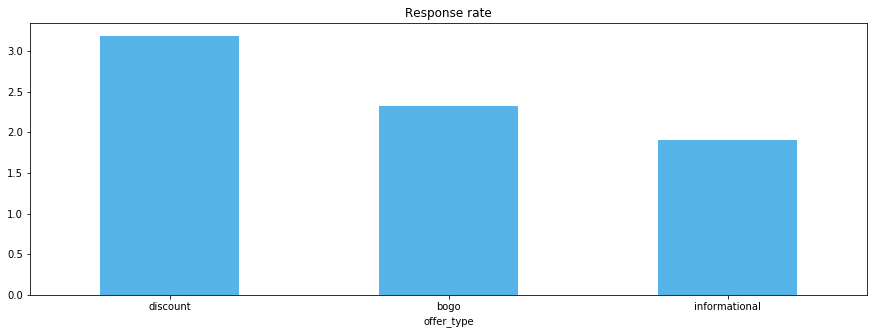

In [33]:
# number of response
stat_response = response.merge(portfolio[['id','offer_type','difficulty','duration','reward']], left_on='received_offer', right_on='id')
stat_response.drop('id', axis=1, inplace=True)

# number of all received offer
stat_all = offer_received.merge(portfolio[['id','offer_type','difficulty','duration','reward']], left_on='received_offer', right_on='id')
stat_all.drop('id', axis=1, inplace=True)

# response rate
((stat_response.groupby('offer_type').size()/stat_all.groupby('offer_type').size())*100).rename("response_rate").\
sort_values(ascending = False).plot.bar(figsize=(15,5), rot=0, title="Response rate",color=sns.color_palette('colorblind')[-1], grid=False);

In [34]:
((stat_response.groupby('offer_type').size()/stat_all.groupby('offer_type').size())*100)

offer_type
bogo             2.324666
discount         3.185673
informational    1.910075
dtype: float64

In [35]:
response_rate = (stat_response.groupby(['offer_type','difficulty','duration','reward']).size()/stat_all.groupby(['offer_type','difficulty','duration','reward']).size()*100).round(2)

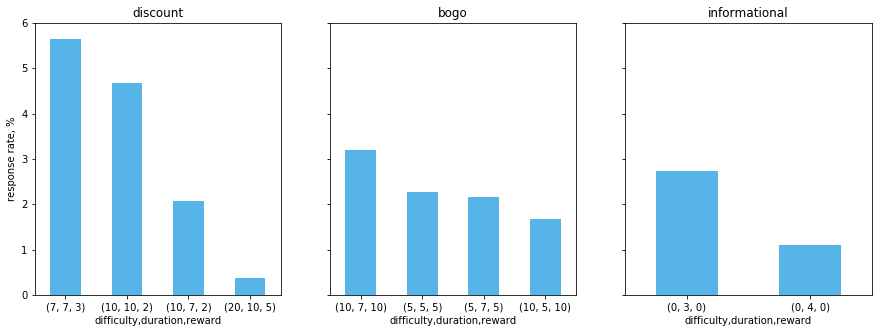

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

idx = pd.IndexSlice
ax1 = response_rate.loc[idx['discount']].sort_values(ascending = False).plot.bar(title='discount', color=sns.color_palette('colorblind')[-1], ax=ax1, rot=0,ylim=(0,6), grid=False)
ax1.set_ylabel("response rate, %")
ax2 = response_rate.loc[idx['bogo']].sort_values(ascending = False).plot.bar(title='bogo', color=sns.color_palette('colorblind')[-1], ax=ax2, rot=0, sharey=True,ylim=(0,6),grid=False)
ax3 = response_rate.loc[idx['informational']].sort_values(ascending = False).plot.bar(title='informational', color=sns.color_palette('colorblind')[-1], ax=ax3,rot=0,sharey=True,ylim=(0,6),grid=False)

In [37]:
response_person = response.drop_duplicates(subset=['person'])
response_person = response_person.merge(profile, left_on='person', right_on = 'id')
response_person.drop('id', axis=1, inplace=True)
response_person = response_person.merge(portfolio[['id','offer_type']], left_on='received_offer', right_on='id')
response_person.drop('id', axis=1, inplace=True)

# convert data of income in profile as category data
response_person['income'] = pd.cut(response_person['income'], 
          bins=[profile['income'].min(), 40000, 60000, 80000,100000, profile['income'].max()], 
          labels = ['<40k', '40k~60k', '60k~80k', '80k~100k', '>100k'])

In [38]:
response_person.head()

,person,received_time,received_offer,age,became_member_on,gender,income,offer_type
0,C_175,0,F_4,46~60,2018,M,60k~80k,bogo
1,C_982,168,F_4,46~60,2017,O,60k~80k,bogo
2,C_2283,0,F_4,46~60,2017,F,60k~80k,bogo
3,C_2611,0,F_4,31~45,2014,M,80k~100k,bogo
4,C_2894,0,F_4,46~60,2017,M,40k~60k,bogo


In [39]:
all_person = offer_received.drop_duplicates('person')
all_person = all_person.merge(profile, left_on='person', right_on='id')
all_person.drop('id', axis=1, inplace=True)
all_person = all_person.merge(portfolio[['id','offer_type']], left_on='received_offer', right_on='id')
all_person.drop('id', axis=1, inplace=True)

# convert data of income as category data
all_person['income'] = pd.cut(all_person['income'], 
          bins=[profile['income'].min(), 40000, 60000, 80000,100000, profile['income'].max()], 
          labels = ['<40k', '40k~60k', '60k~80k', '80k~100k', '>100k'])

In [40]:
all_person.head()

,person,received_time,received_offer,age,became_member_on,gender,income,offer_type
0,C_4,0,F_4,61~80,2017,F,80k~100k,bogo
1,C_30,0,F_4,46~60,2014,M,40k~60k,bogo
2,C_35,0,F_4,31~45,2015,M,<40k,bogo
3,C_43,0,F_4,31~45,2018,M,<40k,bogo
4,C_48,0,F_4,46~60,2017,F,60k~80k,bogo


In [47]:
def profile_plot(key, rot):
    """
    plot demographic difference on key variable bewteen response_person and all_person.  
    
    """
    
    underlying = response_person.groupby(['offer_type', key])['person'].count().groupby(level=0).apply(lambda x: x/x.sum() * 100).round(2)
    overall = all_person.groupby(['offer_type',key])['person'].count().groupby(level=0).apply(lambda x: x/x.sum() * 100).round(2)
    
    profile_invest = pd.DataFrame(underlying.rename('Response')).join(overall.rename('Overall'))
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    idx = pd.IndexSlice
    
    y_limit = round(profile_invest.max().max())+1
    profile_invest .loc[idx['discount']].plot.bar(title="discount",ax=ax1, rot=rot, ylim=(0,y_limit))
    profile_invest .loc[idx['bogo']].plot.bar(title="bogo",ax=ax2, rot=rot,legend=False,ylim=(0, y_limit))
    profile_invest .loc[idx['informational']].plot.bar(title="informational",ax=ax3,rot=rot, legend=False,ylim=(0,y_limit));
    
    plt.show()

In [48]:
def profile_plot_1(key, rot=0, color=sns.color_palette('colorblind')[-1]):
    """
    plot response rate on key demographic variable for response_person. 
    
    """
    
    underlying = response_person.groupby(['offer_type', key])['person'].count()
    overall = all_person.groupby(['offer_type',key])['person'].count()
    
    profile_invest = ((underlying/overall)*100).rename("response_rate")
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    idx = pd.IndexSlice
    
    y_limit = round(profile_invest.max().max())+1
    profile_invest .loc[idx['discount']].plot.bar(title="discount",ax=ax1, rot=rot, ylim=(0,y_limit), legend=False, color=color,grid=False)
    ax1.set_ylabel("response rate, %")
    profile_invest .loc[idx['bogo']].plot.bar(title="bogo",ax=ax2, rot=rot,legend=False,ylim=(0, y_limit),color=color, grid=False)
    profile_invest .loc[idx['informational']].plot.bar(title="informational",ax=ax3,rot=rot, legend=False,ylim=(0,y_limit),color=color, grid=False);
    
    
    plt.show()

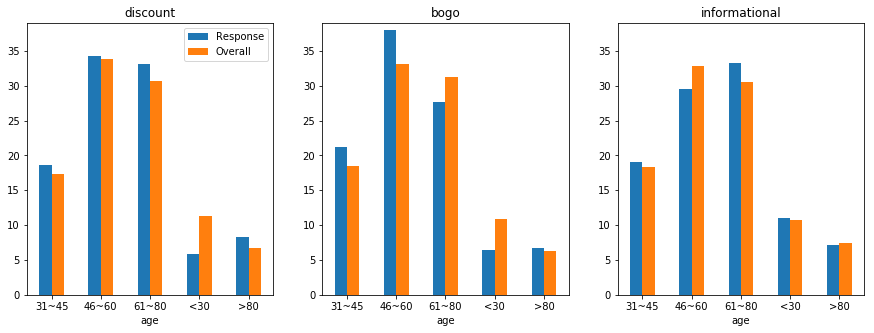

In [49]:
profile_plot('age', 0)

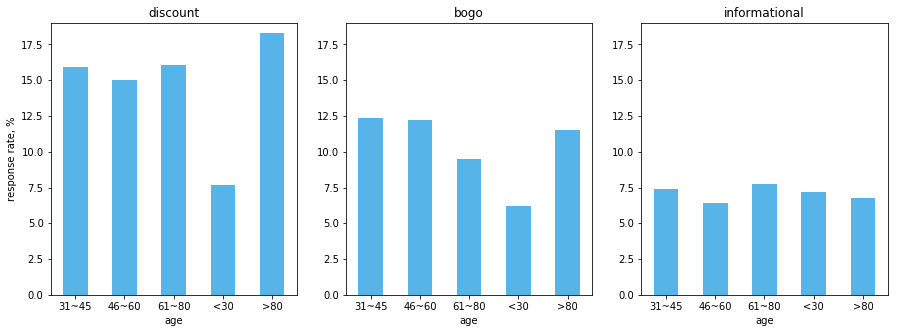

In [50]:
profile_plot_1('age',0)

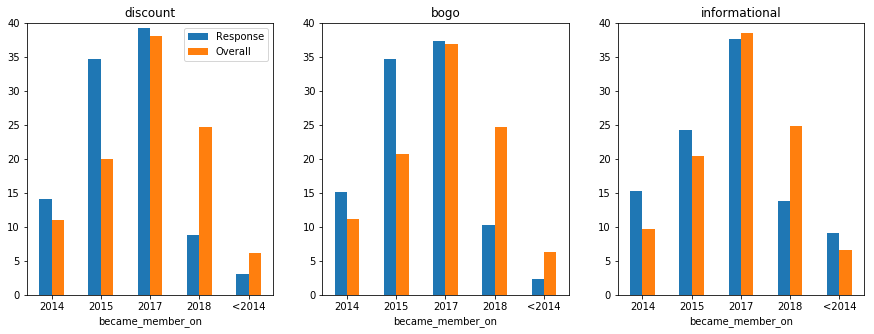

In [51]:
profile_plot('became_member_on',0)

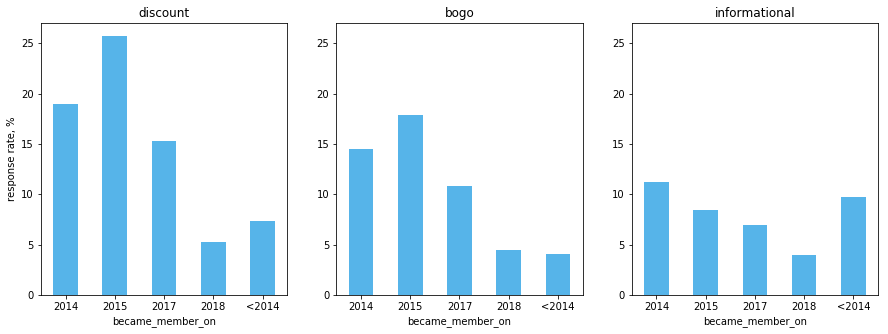

In [52]:
profile_plot_1('became_member_on',0)

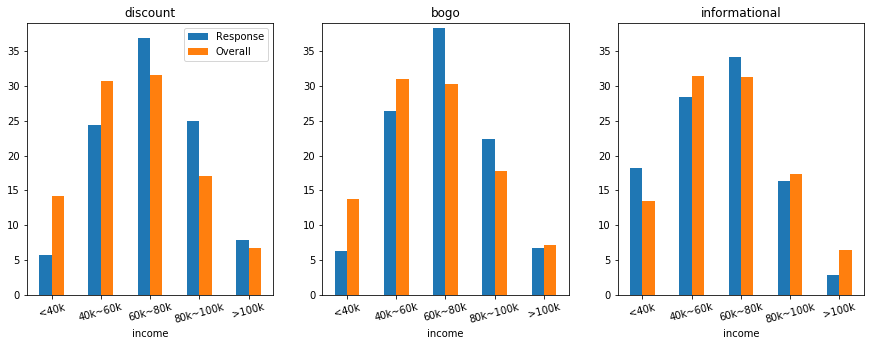

In [53]:
profile_plot('income', 15)

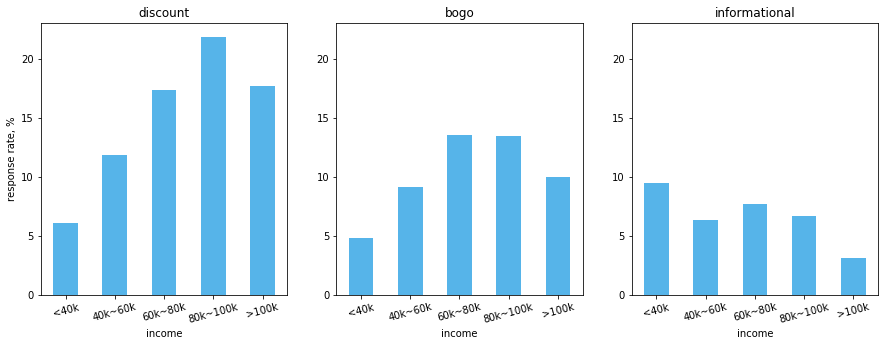

In [54]:
profile_plot_1('income', 15)

In [55]:
# merge proflle and response in order to know who is responsive to coffee offers
df = profile.merge(response[['person','received_offer']], left_on='id', right_on='person', how='left')
df.drop('person', axis=1, inplace=True)

# join average transaction data to proflie  
df = df.set_index('id').join(transaction.groupby('person')['amount'].sum(), how="inner")

# drop those customers who didn't receive any coffee offers
exclude_ind = np.array(list(set(transaction['person'])-set(offer_received['person'])))
df = df.iloc[np.where(np.logical_not(np.isin(df.index.values, exclude_ind)))[0]]

In [56]:
# dummy variables
df = pd.get_dummies(df)

In [63]:
# normalize scalar
scalar = MinMaxScaler(copy=True, feature_range=(0, 1)).fit(df)
scaled_df = scalar.transform(df)

In [64]:
y = scaled_df[:,1]
X = np.delete(scaled_df,1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [65]:
reg = LinearRegression().fit(X_train, y_train)
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))))

 R2 for train set: 0.21, 
 R2 for test set: 0.23


In [66]:
regr = RandomForestRegressor(max_depth=7)
regr.fit(X_train,y_train)
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,regr.predict(X_train)), r2_score(y_test,regr.predict(X_test))))

 R2 for train set: 0.26, 
 R2 for test set: 0.19


In [67]:
svr = SVR()
svr.fit(X_train, y_train) 
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,svr.predict(X_train)), r2_score(y_test,svr.predict(X_test))))

 R2 for train set: -0.11, 
 R2 for test set: -0.08
